# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key=''
binance_api_secret=''
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')
inventory_weights

{'BTCUSDT': 0.39549999999999996,
 'JASMYUSDT': 0.1869,
 'ETHUSDT': 0.1389,
 'SOLUSDT': 0.1105,
 'MKRUSDT': 0.0593,
 'BBUSDT': 0.0535,
 'PEPEUSDT': 0.0331,
 'BNBUSDT': 0.0223,
 'TRXUSDT': 0.0,
 'FETUSDT': 0.0}

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))

### Positions

In [11]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

2024-05-05 00:00:00
2024-06-04 00:00:00
LDUMAUSDT not retrieved


In [12]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,5))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [13]:
historical_ptf=pd.DataFrame()

In [14]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

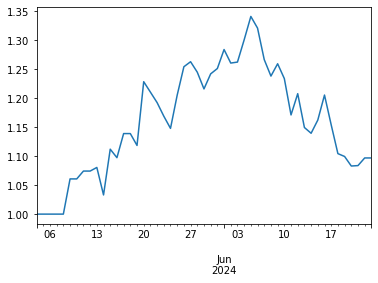

In [15]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [16]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [17]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [18]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'AGIXUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT',
       'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT',
       'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT',
       'NEOUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [19]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[13]-0.3}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.300000
BNBUSDT,0.239287
ETHUSDT,0.150000
JASMYUSDT,0.132107
PENDLEUSDT,0.099133
PEPEUSDT,0.079473


In [20]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.55
BTCUSDT,0.30
ETHUSDT,0.15


## Real Portfolio vs Optimal

In [21]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current*100],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,675.573292,39.554738,30.0,9.554738
JASMYUSDT,319.161532,18.686871,55.0,-36.313129
ETHUSDT,237.213521,13.888824,15.0,-1.111176
SOLUSDT,188.674105,11.046847,0.0,0.000000
MKRUSDT,101.353568,5.934240,0.0,0.000000
BBUSDT,91.334746,5.347639,0.0,0.000000
PEPEUSDT,56.530975,3.309882,0.0,0.000000
BNBUSDT,38.073642,2.229207,0.0,0.000000
TRXUSDT,0.015185,0.000889,0.0,0.000000
FETUSDT,0.014758,0.000864,0.0,0.000000


In [22]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory*100],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,675.573292,39.554738,30.0000,9.554738
JASMYUSDT,319.161532,18.686871,13.2107,5.476171
ETHUSDT,237.213521,13.888824,15.0000,-1.111176
SOLUSDT,188.674105,11.046847,0.0000,0.000000
MKRUSDT,101.353568,5.934240,0.0000,0.000000
BBUSDT,91.334746,5.347639,0.0000,0.000000
PEPEUSDT,56.530975,3.309882,7.9473,-4.637418
BNBUSDT,38.073642,2.229207,23.9287,-21.699493
TRXUSDT,0.015185,0.000889,0.0000,0.000000
FETUSDT,0.014758,0.000864,0.0000,0.000000


## Risk Reward Analysis

<AxesSubplot:>

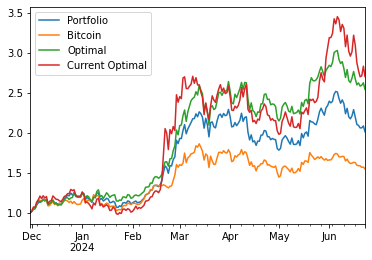

In [23]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [24]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

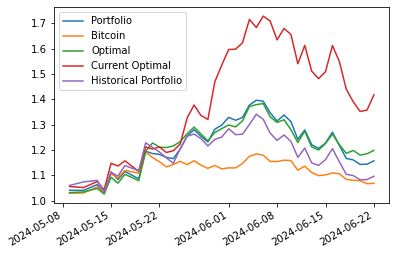

In [25]:
(1+portfolio_perf.loc[positions.index]).cumprod().plot()

In [26]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.511584
dtype: float64

In [27]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.505629
Bitcoin                 0.441640
Optimal                 0.512800
Current Optimal         0.746192
Historical Portfolio    0.489063
dtype: float64

In [28]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.216935,0.226169,0.158682,0.055670,0.103012
BTCUSDT,0.116039,0.192039,0.222720,0.066755,0.155965
ETHUSDT,0.053065,0.093111,0.126871,0.022066,0.104805
JASMYUSDT,0.241520,0.196318,0.196297,0.088869,0.107428
PENDLEUSDT,0.163964,0.137180,0.138045,0.045634,0.092411
PEPEUSDT,0.208478,0.155182,0.157385,0.046763,0.110622


In [29]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.025498,0.374270,0.220086,0.067033,0.153053
JASMYUSDT,1.609611,0.258646,0.322317,0.161778,0.160539
ETHUSDT,0.347174,0.149403,0.118220,0.021914,0.096307
SOLUSDT,-0.317418,0.088921,0.106966,0.016418,0.090549
MKRUSDT,-0.207127,0.045864,0.051248,0.005257,0.045991
BBUSDT,-0.391143,0.031077,0.134171,0.039159,0.095012
PEPEUSDT,0.000498,0.031456,0.034981,0.005005,0.029976
BNBUSDT,-0.016098,0.020364,0.012011,0.000347,0.011664


## Value At Risk

### Historical

In [30]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04768403265641569, -0.06398950447974848)

In [31]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04199461554604819, -0.04940723251952923)

### Parametric

In [32]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.05313430960044389, -0.06810349408479027)

In [33]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05397516250896104, -0.06918123503055573)

### Multivariate

In [34]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.048055323439832084, -0.06201388622005858)

In [35]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05265475817316467, -0.06632041907786015)

### Copulas

In [36]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04709887886484233, -0.06008238988246904)

In [37]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05363349260554111, -0.06625966589316841)

In [38]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0482237113477977, -0.061113289749618147)

In [39]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05271013074626062, -0.066849699036885)

### Monte Carlo

In [40]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054173219589878835, -0.06675433594301612)

In [41]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05468467798296204, -0.06912358689919389)

### VaR Violation

In [42]:
var_data=rolling_var(returns_to_use,opt_weights,window=15,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.027839,-0.051648,-0.045685,0.000985
2023-12-31,-0.027839,-0.051996,-0.047528,-0.004740
2024-01-01,-0.027219,-0.052556,-0.043239,0.036921
2024-01-02,-0.027219,-0.053717,-0.045269,-0.010098
2024-01-03,-0.033671,-0.059106,-0.054562,-0.034446
...,...,...,...,...
2024-06-19,-0.047681,-0.063205,-0.071560,0.009413
2024-06-20,-0.047681,-0.062644,-0.072999,-0.015261
2024-06-21,-0.047681,-0.062763,-0.072223,0.004457
2024-06-22,-0.047681,-0.061280,-0.066629,0.011377


In [43]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=5,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-18,-0.032113,-0.108670,-0.095981,0.008048
2024-05-19,-0.027173,-0.105420,-0.088278,-0.026179
2024-05-20,-0.027173,-0.121504,-0.101757,0.099784
2024-05-21,-0.025428,-0.113263,-0.089968,-0.007411
2024-05-22,-0.025428,-0.114838,-0.101183,-0.002751
2024-05-23,-0.025522,-0.117606,-0.105346,-0.009739
2024-05-24,-0.009646,-0.110350,-0.096430,-0.004561
2024-05-25,-0.009646,-0.041056,-0.039912,0.032893
2024-05-26,-0.009532,-0.055922,-0.042557,0.042187
2024-05-27,-0.009532,-0.052945,-0.036071,0.019948


<AxesSubplot:>

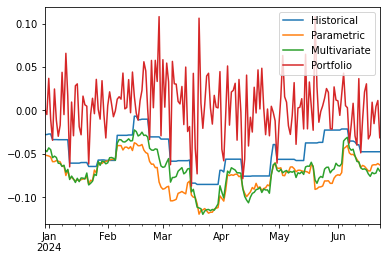

In [44]:
var_data.plot()

<AxesSubplot:>

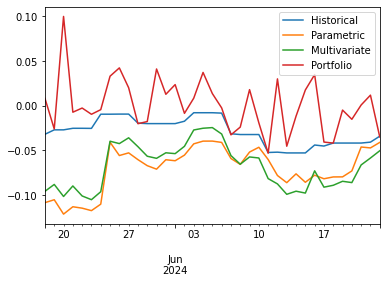

In [45]:
current_var_data.plot()

In [46]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.062147,0.0,0.0
Kupiec Stat,0.51212,18.157826,18.157826
P-value,0.474222,0.00002,0.00002


In [47]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.135135,0.0,0.0
Kupiec Stat,3.933645,3.795704,3.795704
P-value,0.047329,0.051384,0.051384


## Principal Component Analysis

In [48]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7599037 , 0.08069076, 0.06263292, 0.04916969, 0.04760293])

In [49]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5851543 , 0.1835249 , 0.110253  , 0.09014081, 0.030927  ])